# Import libraries

In [1]:
# Common
from common import data_paths as dp
from common import bigram_processing as bp
from common import globals as gl
from common import data_processing as dproc
from common import data_loading as dl

# General
import numpy as np
import pandas as pd
import scapy.all as scapy
import pickle
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, auc, classification_report
import re

# Shannon entropy

In [2]:
def qname_entropy_for_levels(qname):
    txt = qname.replace('.','').lower()
    single_chars = set(txt)
    return -sum([txt.count(c)/len(txt) * np.log2(txt.count(c)/len(txt)) for c in single_chars])        

In [3]:
print(qname_entropy_for_levels("53.LfvVycvfEcP7pl5qFwbOyeqWw5YwgGWwRojcjj"))

3.920950594454668


# Load attack files

In [4]:
data_attack = dl.load_ts(dp.PCAP_PATH + dp.ATTACK_LIGHT_PATH + dp.ATTACK_PATH + 'light_audio.pcap')
print(data_attack[:10])
print(len(data_attack))

[{'time': 1605986007.034573, 'query': '200.20.168.192.in-add.', 'src': '18:66:da:9b:e3:7e', 'len': 53}, {'time': 1605986007.034607, 'query': '200.20.168.192.in-addr.arpa.', 'src': '18:66:da:9b:e3:7e', 'len': 53}, {'time': 1605986007.44471, 'query': '200.20.168.192.in-add.', 'src': '18:66:da:9b:e3:7e', 'len': 53}, {'time': 1605986007.444721, 'query': '200.20.168.192.in-addr.arpa.', 'src': '18:66:da:9b:e3:7e', 'len': 53}, {'time': 1605986007.857156, 'query': '252.0.0.224.in-addr.a.', 'src': '18:66:da:9b:e3:7e', 'len': 50}, {'time': 1605986007.857202, 'query': '252.0.0.224.in-addr.arpa.', 'src': '18:66:da:9b:e3:7e', 'len': 50}, {'time': 1605986008.267312, 'query': '252.0.0.224.in-addr.arpa.', 'src': '18:66:da:9b:e3:7e', 'len': 50}, {'time': 1605986008.267318, 'query': '252.0.0.224.in-addr.a.', 'src': '18:66:da:9b:e3:7e', 'len': 50}, {'time': 1605986008.680076, 'query': '3.0.0.0.1.0.0.0.0.0.0.', 'src': '18:66:da:9b:e3:7e', 'len': 98}, {'time': 1605986008.680091, 'query': '3.0.0.0.1.0.0.0.0

In [5]:
data_attack2 = dl.load_ts(dp.PCAP_PATH + dp.ATTACK_LIGHT_PATH + dp.ATTACK_PATH + 'light_compressed.pcap')
print(data_attack2[:10])
print(len(data_attack2))

[{'time': 1605996546.308662, 'query': '2.20.168.192.in-addr.arpa.', 'src': '18:66:da:9b:e3:7e', 'len': 51}, {'time': 1605996546.308662, 'query': '2.20.168.192.in-addr..', 'src': '18:66:da:9b:e3:7e', 'len': 51}, {'time': 1605996546.721159, 'query': '3.0.0.0.1.0.0.0.0.0.0.', 'src': '18:66:da:9b:e3:7e', 'len': 98}, {'time': 1605996546.721161, 'query': '3.0.0.0.1.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.', 'src': '18:66:da:9b:e3:7e', 'len': 98}, {'time': 1605996547.131902, 'query': '3.0.0.0.1.0.0.0.0.0.0.', 'src': '18:66:da:9b:e3:7e', 'len': 98}, {'time': 1605996547.132087, 'query': '3.0.0.0.1.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.', 'src': '18:66:da:9b:e3:7e', 'len': 98}, {'time': 1605996547.544286, 'query': '252.0.0.224.in-addr.a.', 'src': '18:66:da:9b:e3:7e', 'len': 50}, {'time': 1605996547.544415, 'query': '252.0.0.224.in-addr.arpa.', 'src': '18:66:da:9b:e3:7e', 'len': 50}, {'time': 1605996547.955713, 'query': '252.0.0.224.in-addr.a.', 'src': '18:66:da:9b:e3:7e', 'len': 50}, {'time': 1605996547.95575

# Load benign files

In [6]:
data_benign = dl.load_ts(dp.PCAP_PATH + dp.ATTACK_LIGHT_PATH + dp.BENIGN_PATH + 'benign.pcap')
print(data_benign[:10])
print(len(data_benign))

[{'time': 1605968334.998699, 'query': '100.20.168.192.in-add.', 'src': '18:66:da:9b:e3:7e', 'len': 53}, {'time': 1605968334.998708, 'query': '100.20.168.192.in-addr.arpa.', 'src': '18:66:da:9b:e3:7e', 'len': 53}, {'time': 1605968335.410983, 'query': '2.20.168.192.in-addr..', 'src': '18:66:da:9b:e3:7e', 'len': 51}, {'time': 1605968335.41101, 'query': '2.20.168.192.in-addr.arpa.', 'src': '18:66:da:9b:e3:7e', 'len': 51}, {'time': 1605968335.821554, 'query': '2.20.168.192.in-addr..', 'src': '18:66:da:9b:e3:7e', 'len': 51}, {'time': 1605968335.821592, 'query': '2.20.168.192.in-addr.arpa.', 'src': '18:66:da:9b:e3:7e', 'len': 51}, {'time': 1605968336.233946, 'query': '150.20.168.192.in-add.', 'src': '18:66:da:9b:e3:7e', 'len': 53}, {'time': 1605968336.234074, 'query': '150.20.168.192.in-addr.arpa.', 'src': '18:66:da:9b:e3:7e', 'len': 53}, {'time': 1605968336.644281, 'query': '150.20.168.192.in-add.', 'src': '18:66:da:9b:e3:7e', 'len': 53}, {'time': 1605968336.644294, 'query': '150.20.168.192.

# Label data

In [7]:
data_labeled = []


for d in data_attack:
    d['time'] = pd.to_datetime(d['time'], unit='s')
    d['entropy'] = qname_entropy_for_levels(d['query'])
    if dproc.not_exfil(d['query']):
        data_labeled.append((d, 1))
    else:
        data_labeled.append((d, 0))
    
print(len([d for d in data_labeled if d[1] == 1]))
print(len([d for d in data_labeled if d[1] == 0]))
print([d for d in data_labeled if d[1] == 1][:10])
print([d for d in data_labeled if d[1] == 0][:10])

print(data_labeled[:10])

49036
4292
[({'time': Timestamp('2020-11-21 19:13:27.034573078'), 'query': '200.20.168.192.in-add.', 'src': '18:66:da:9b:e3:7e', 'len': 53, 'entropy': 3.292770193936991}, 1), ({'time': Timestamp('2020-11-21 19:13:27.034606934'), 'query': '200.20.168.192.in-addr.arpa.', 'src': '18:66:da:9b:e3:7e', 'len': 53, 'entropy': 3.5383105956150054}, 1), ({'time': Timestamp('2020-11-21 19:13:27.444710016'), 'query': '200.20.168.192.in-add.', 'src': '18:66:da:9b:e3:7e', 'len': 53, 'entropy': 3.292770193936991}, 1), ({'time': Timestamp('2020-11-21 19:13:27.444720984'), 'query': '200.20.168.192.in-addr.arpa.', 'src': '18:66:da:9b:e3:7e', 'len': 53, 'entropy': 3.5383105956150054}, 1), ({'time': Timestamp('2020-11-21 19:13:27.857156038'), 'query': '252.0.0.224.in-addr.a.', 'src': '18:66:da:9b:e3:7e', 'len': 50, 'entropy': 3.125}, 1), ({'time': Timestamp('2020-11-21 19:13:27.857202053'), 'query': '252.0.0.224.in-addr.arpa.', 'src': '18:66:da:9b:e3:7e', 'len': 50, 'entropy': 3.2608281712244547}, 1), ({'t

In [8]:
data_labeled2 = []


for d in data_attack2:
    d['time'] = pd.to_datetime(d['time'], unit='s')
    d['entropy'] = qname_entropy_for_levels(d['query'])
    if dproc.not_exfil(d['query']):
        data_labeled2.append((d, 1))
    else:
        data_labeled2.append((d, 0))
    
print(len([d for d in data_labeled2 if d[1] == 1]))
print(len([d for d in data_labeled2 if d[1] == 0]))
print([d for d in data_labeled2 if d[1] == 1][:10])
print([d for d in data_labeled2 if d[1] == 0][:10])

print(data_labeled2[:10])

28355
10065
[({'time': Timestamp('2020-11-21 22:09:06.308661938'), 'query': '2.20.168.192.in-addr.arpa.', 'src': '18:66:da:9b:e3:7e', 'len': 51, 'entropy': 3.546439344671015}, 1), ({'time': Timestamp('2020-11-21 22:09:06.308661938'), 'query': '2.20.168.192.in-addr..', 'src': '18:66:da:9b:e3:7e', 'len': 51, 'entropy': 3.452819531114783}, 1), ({'time': Timestamp('2020-11-21 22:09:06.721158981'), 'query': '3.0.0.0.1.0.0.0.0.0.0.', 'src': '18:66:da:9b:e3:7e', 'len': 98, 'entropy': 0.8658566174572235}, 1), ({'time': Timestamp('2020-11-21 22:09:06.721160889'), 'query': '3.0.0.0.1.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.', 'src': '18:66:da:9b:e3:7e', 'len': 98, 'entropy': 0.5489544344250401}, 1), ({'time': Timestamp('2020-11-21 22:09:07.131901979'), 'query': '3.0.0.0.1.0.0.0.0.0.0.', 'src': '18:66:da:9b:e3:7e', 'len': 98, 'entropy': 0.8658566174572235}, 1), ({'time': Timestamp('2020-11-21 22:09:07.132086991'), 'query': '3.0.0.0.1.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.', 'src': '18:66:da:9b:e3:7e', 'len': 9

In [9]:
for i in range(len(data_benign)):
    data_benign[i]['time'] = pd.to_datetime(data_benign[i]['time'], unit='s')
    data_benign[i]['entropy'] = qname_entropy_for_levels(data_benign[i]['query'])
    
print(data_benign[:10])

[{'time': Timestamp('2020-11-21 14:18:54.998698950'), 'query': '100.20.168.192.in-add.', 'src': '18:66:da:9b:e3:7e', 'len': 53, 'entropy': 3.292770193936991}, {'time': Timestamp('2020-11-21 14:18:54.998708010'), 'query': '100.20.168.192.in-addr.arpa.', 'src': '18:66:da:9b:e3:7e', 'len': 53, 'entropy': 3.5383105956150054}, {'time': Timestamp('2020-11-21 14:18:55.410983086'), 'query': '2.20.168.192.in-addr..', 'src': '18:66:da:9b:e3:7e', 'len': 51, 'entropy': 3.452819531114783}, {'time': Timestamp('2020-11-21 14:18:55.411010027'), 'query': '2.20.168.192.in-addr.arpa.', 'src': '18:66:da:9b:e3:7e', 'len': 51, 'entropy': 3.546439344671015}, {'time': Timestamp('2020-11-21 14:18:55.821553946'), 'query': '2.20.168.192.in-addr..', 'src': '18:66:da:9b:e3:7e', 'len': 51, 'entropy': 3.452819531114783}, {'time': Timestamp('2020-11-21 14:18:55.821592093'), 'query': '2.20.168.192.in-addr.arpa.', 'src': '18:66:da:9b:e3:7e', 'len': 51, 'entropy': 3.546439344671015}, {'time': Timestamp('2020-11-21 14:18

# Prophet

## Train

In [10]:

df_benign = pd.DataFrame(data_benign)
df_benign['time'] = pd.to_datetime(df_benign['time'], unit='s')
df_benign['time'] = df_benign['time'] - pd.Timedelta(hours=4)
df_benign.sort_values(by='time', inplace=True)

df_benign_prophet = df_benign[['time','entropy']]
df_benign_prophet.columns = ['ds', 'y']

print(df_benign_prophet.head())
print(df_benign_prophet.tail())

                             ds         y
0 2020-11-21 10:18:54.998698950  3.292770
1 2020-11-21 10:18:54.998708010  3.538311
2 2020-11-21 10:18:55.410983086  3.452820
3 2020-11-21 10:18:55.411010027  3.546439
4 2020-11-21 10:18:55.821553946  3.452820
                                  ds         y
101583 2020-11-21 14:09:49.385001898  3.260828
101584 2020-11-21 14:09:49.797344923  3.454822
101585 2020-11-21 14:09:49.797486067  3.663533
101586 2020-11-21 14:09:50.207705021  3.454822
101587 2020-11-21 14:09:50.207729101  3.663533


In [11]:
from prophet import Prophet

# Train model
model = Prophet(weekly_seasonality=False, yearly_seasonality=False, daily_seasonality=False, holidays=None)

model.fit(df_benign_prophet)



/home/tux/Desktop/Licenta/AplicatieDetectieAnomalii/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


14:53:09 - cmdstanpy - INFO - Chain [1] start processing
14:53:16 - cmdstanpy - INFO - Chain [1] done processing


In [12]:
with open('prophet_ts_lower.pkl', 'wb') as f:
    pickle.dump(model, f)

## Use to predict

In [11]:
df_attack = pd.DataFrame(data_attack)
df_attack['time'] = pd.to_datetime(df_attack['time'], unit='s')
df_attack['time'] = df_attack['time'] - pd.Timedelta(hours=4)
df_attack.sort_values(by='time', inplace=True)

df_attack_prophet = df_attack[['time','entropy']]
df_attack_prophet.columns = ['ds', 'y']

print(df_attack_prophet.tail())
print(df_attack_prophet.head())

                                 ds         y
53323 2020-11-21 18:06:52.246382952  3.538311
53324 2020-11-21 18:06:52.658248901  3.292770
53325 2020-11-21 18:06:52.658281088  3.538311
53326 2020-11-21 18:06:53.068574905  3.292770
53327 2020-11-21 18:06:53.068591118  3.538311
                             ds         y
0 2020-11-21 15:13:27.034573078  3.292770
1 2020-11-21 15:13:27.034606934  3.538311
2 2020-11-21 15:13:27.444710016  3.292770
3 2020-11-21 15:13:27.444720984  3.538311
4 2020-11-21 15:13:27.857156038  3.125000


In [12]:
future = df_attack_prophet[['ds']]

print(future.tail())
print(future.head())

forecast = model.predict(future)

                                 ds
53323 2020-11-21 18:06:52.246382952
53324 2020-11-21 18:06:52.658248901
53325 2020-11-21 18:06:52.658281088
53326 2020-11-21 18:06:53.068574905
53327 2020-11-21 18:06:53.068591118
                             ds
0 2020-11-21 15:13:27.034573078
1 2020-11-21 15:13:27.034606934
2 2020-11-21 15:13:27.444710016
3 2020-11-21 15:13:27.444720984
4 2020-11-21 15:13:27.857156038


## Use first forecast for logistic regression

In [13]:
X = []
periods = len(df_attack)
yhats = forecast[:periods]['yhat']
for i in range(periods):
    X.append([yhats[i], df_attack_prophet['y'][i]])
y = [d[1] for d in data_labeled]

print(len(data_labeled))
print(len(y))

53328
53328


## Logistic regression

In [14]:
from sklearn.linear_model import LogisticRegression

strat_shuffle_split = StratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=42)

pipe_lr = Pipeline(steps=[('lr', LogisticRegression(penalty='l2', max_iter=500))], verbose=True)
params = {
    'lr__C': [0.01, 0.1, 1, 10, 100, 1000],
}

grid_lr = GridSearchCV(pipe_lr, param_grid=params, cv=strat_shuffle_split, verbose=1, n_jobs=9, scoring='precision')


Fitting 3 folds for each of 6 candidates, totalling 18 fits
[Pipeline] ................ (step 1 of 1) Processing lr, total=   0.2s
[Pipeline] ................ (step 1 of 1) Processing lr, total=   0.2s
[Pipeline] ................ (step 1 of 1) Processing lr, total=   0.1s
[Pipeline] ................ (step 1 of 1) Processing lr, total=   0.2s
[Pipeline] ................ (step 1 of 1) Processing lr, total=   0.2s
[Pipeline] ................ (step 1 of 1) Processing lr, total=   0.2s
[Pipeline] ................ (step 1 of 1) Processing lr, total=   0.1s
[Pipeline] ................ (step 1 of 1) Processing lr, total=   0.1s
[Pipeline] ................ (step 1 of 1) Processing lr, total=   0.1s
[Pipeline] ................ (step 1 of 1) Processing lr, total=   0.1s
[Pipeline] ................ (step 1 of 1) Processing lr, total=   0.1s
[Pipeline] ................ (step 1 of 1) Processing lr, total=   0.1s
[Pipeline] ................ (step 1 of 1) Processing lr, total=   0.1s
[Pipeline] ......

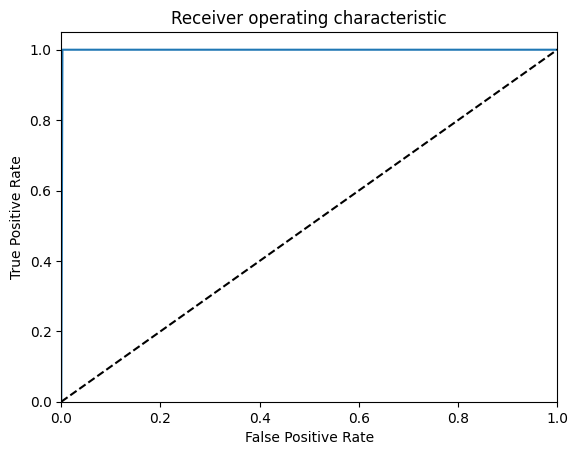

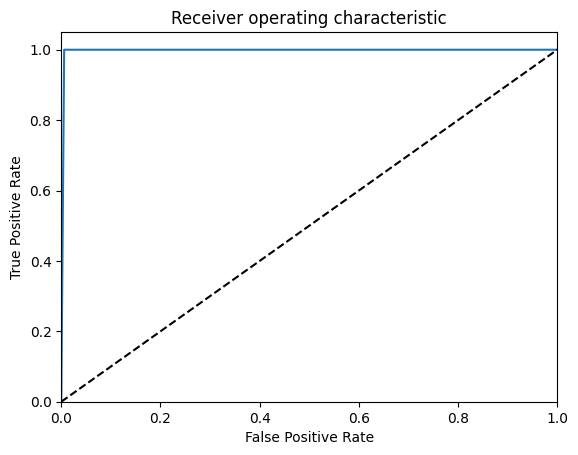

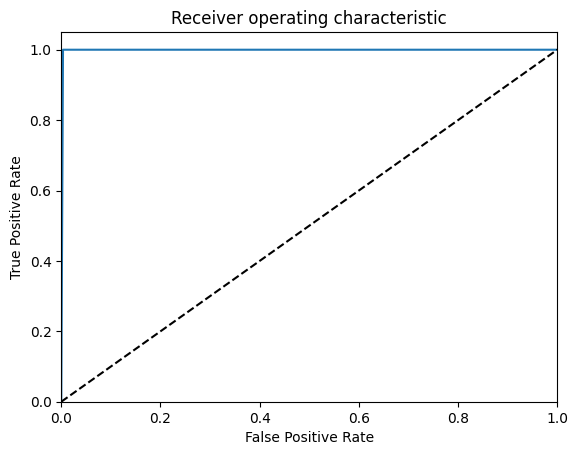

In [15]:
batch_i = 1

for train_index, test_index in strat_shuffle_split.split(X, y):
    X_train, X_test = [X[i] for i in train_index], [X[i] for i in test_index]
    y_train, y_test = [y[i] for i in train_index], [y[i] for i in test_index]
    
    grid_lr.fit(X_train, y_train)
    print('Fit done')
    
    y_pred = grid_lr.predict(X_test)
    print('Predict done')
    
    print('Classification report:\n', classification_report(y_test, y_pred))
    
    
    # Calculate roc and auc
    roc_auc = roc_auc_score(y_test, y_pred)
    print('ROC AUC:', roc_auc)
    
    # Roc curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    auc_score = auc(fpr, tpr)
    
    print('AUC:', auc_score)
    
    fig, ax = plt.subplots()
    ax.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic')
    
    # Save
    # current_time = time()
    fig.savefig(f'roc_auc_lr_ts_lower_{batch_i}.png')
    batch_i += 1
    
print('Best params:', grid_lr.best_params_)
print('Best score:', grid_lr.best_score_)
print('Best estimator:', grid_lr.best_estimator_)

## Test on next attack

In [18]:
df_attack2 = pd.DataFrame(data_attack2)
df_attack2['time'] = pd.to_datetime(df_attack2['time'], unit='s')
df_attack2['time'] = df_attack2['time'] - pd.Timedelta(hours=4)
df_attack2.sort_values(by='time', inplace=True)

df_attack_prophet2 = df_attack2[['time','entropy']]
df_attack_prophet2.columns = ['ds', 'y']

print(df_attack_prophet2.head())

                             ds         y
0 2020-11-21 18:09:06.308661938  3.546439
1 2020-11-21 18:09:06.308661938  3.452820
2 2020-11-21 18:09:06.721158981  0.865857
3 2020-11-21 18:09:06.721160889  0.548954
4 2020-11-21 18:09:07.131901979  0.865857


In [19]:
future = df_attack_prophet2[['ds']]

print(future.tail())
print(future.head())

forecast = model.predict(future)

                                 ds
38415 2020-11-21 19:49:54.070147038
38416 2020-11-21 19:49:54.480348110
38417 2020-11-21 19:49:54.480350971
38418 2020-11-21 19:49:54.893039942
38419 2020-11-21 19:49:54.893073082
                             ds
0 2020-11-21 18:09:06.308661938
1 2020-11-21 18:09:06.308661938
2 2020-11-21 18:09:06.721158981
3 2020-11-21 18:09:06.721160889
4 2020-11-21 18:09:07.131901979


In [20]:
periods = len(data_attack2)
yhats = np.array(forecast[:periods]['yhat'])

X2 = []
for i in range(periods):
    X2.append([yhats[i], df_attack_prophet2['y'][i]])
y2 = [d[1] for d in data_labeled2]

print(periods)
print(len(X2))
print(len(y2))

t = 0
for i in range(len(X2)):
    if t >= 10:
        break
    
    if t < 5 and y2[i] == 1 and data_attack2[i]['query'].endswith('com.'):
        print(data_attack2[i]['query'],X2[i], y2[i])
        t += 1
    elif t >= 5 and y2[i] == 0:
        print(data_attack2[i]['query'],X2[i], y2[i])
        t += 1
    
        

38420
38420
38420
ctldl.windowsupdate.com. [2.748195433263623, 3.6897037321995474] 1
tile-service.weather.microsoft.com. [2.7479292966114377, 3.6837421818302887] 1
go.microsoft.com. [2.7475747002332027, 2.950212064914747] 1
settings-win.data.microsoft.com. [2.747574457774053, 3.7264741182543752] 1
tsfe.trafficshaping.dsp.mp.microsoft.com. [2.746227407691653, 3.742730873716943] 1
2207.bvtP_5cV6vUhPTEJpdbIRxVal3R0--pVeq7U. [2.746226852151869, 4.381687083026441] 0
2208.CHdGjQO1if0YeAiwI9LB8DwVPSTiuwKs-FfO. [2.746226078223619, 4.584183719779189] 0
2209.j7tGgtRt9rt7f8z3uCe47lyoAJpirTka4nMM. [2.7462253042713956, 4.443942707918269] 0
2210.KCeETLUtqjxBjsRCUEur64JTFjMeqyhY-1_m. [2.7462245303338415, 4.334183719779188] 0
2211.aCfj8zkUoCgd5G0xgOneaD4ci2QilKvzg00i. [2.74622375661886, 4.3464393446710154] 0


In [24]:

best_lr_model = grid_lr.best_estimator_
y_pred = best_lr_model.predict(X2)
print('Classification report:\n', classification_report(y2, y_pred))

# P# Print all misclassified
falses = 0
falert = 0
nonalert = 0
falerts = []
nonalerts=[]
ppp= 0
# ppps = []
qqq = 0
# qqqs = []
for i in range(len(y2)):
    if y2[i] != y_pred[i]:
        falses += 1
        if y_pred[i] == 0:
            falert += 1
            falerts.append(data_labeled2[i][0]['query'])
        else:
            nonalert += 1
            nonalerts.append(data_labeled2[i][0]['query'])
        # print(f"'{X[i]}'", y[i], y_pred[i])
    if y2[i] == 1 and y_pred[i] == 1:
        ppp += 1
    if y2[i] == 0 and y_pred[i] == 0:
        qqq += 1
# print(falses)
alerts = len([d for d in y2 if d == 0])
good = len([d for d in y2 if d == 1])

print(falert)
print(good)
print(ppp)
print(falert/good * 100)
print(ppp/good * 100)
print(falerts[:10])
print('=======')
print(nonalert)
print(alerts)
print(qqq)
print(nonalert/alerts * 100)
print(qqq/alerts * 100)
print(nonalerts[:10])

Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     10065
           1       1.00      1.00      1.00     28355

    accuracy                           1.00     38420
   macro avg       1.00      1.00      1.00     38420
weighted avg       1.00      1.00      1.00     38420

0
28355
28355
0.0
100.0
[]
26
10065
10039
0.25832091405861896
99.74167908594139
['53.LfvVycvfEcP7pl5qFwbOyeqWw5YwgGWwRojcjj.', '77.uVAAUGaCs7g0CUwwgJ4EJb4VPa9_yCyZc7CYNS.', '554.6FAGngkp4YPf6KGZ3hzGpNpb8hXfDKWkkkZ1I.', '606.dvaZvoBOk0vFJpVMvHv27kANLL0Vy-nfVrp6V.', '1159.PQPIpn-9p7ASzJJa1YbSZMDWfzIN15vFpZPz.', '1227.xrzsNVkMgEx62OmPJEpQ2O98Dk2NMv2xmMpm.', '1322.vhBjg2g3gD2wqJImhRFHfGUrihl2eBmisbEG.', '1545.UCxUo-eyhlhn50yoXP4zf8u6zhyxyoyO1eoC.', '2115.wIWVml1qaNPJOJOJ-PpaIkPXnXwXPfHSjpIK.', '2223.Ozxe--Sj2Eor4XZEHyR2FHJnq2yhmLxxp_He.']


# Save the model

In [22]:
with open('logisticregression_ts_lower.pkl', 'wb') as f:
    pickle.dump(best_lr_model, f)

## Export data about the model

In [25]:
roc_auc = roc_auc_score(y2, y_pred)
print(f'ROC AUC: {roc_auc}')

fpr, tpr, _ = roc_curve(y2, y_pred)

roc_auc = auc(fpr, tpr)

TP = 0
TN = 0
FP = 0
FN = 0

for i in range(len(y2)):
    if y2[i] == y_pred[i]:
        # True
        if y2[i] == 1:
            TP += 1
        else:
            TN += 1
    else:
        # False
        if y_pred[i] == 1:
            FP += 1
        else:
            FN += 1
            
accuracy = (TP + TN)/(TP + TN + FN + FP)

precision1 = TP / (TP + FP)
precision0 = TN / (TN + FN)

recall1 = TP / (TP + FN)
recall0 = TN / (TN + FP)

f11 = 2 * (precision1 * recall1)/(precision1 + recall1)
f10 = 2 * (precision0 * recall0)/(precision0 + recall0)

all_attack = len([d for d in y2 if d == 0])

lower_ts = {
    'roc_auc': roc_auc,
    'accuracy': accuracy,
    'benign':{
        'precision': precision1,
        'recall': recall1,
        'f1': f11
    },
    'attack':{
        'precision': precision0,
        'recall': recall0,
        'f1': f10
    },
    'tp': TP,
    'tn': TN,
    'fp': FP,
    'fn': FN,
    'false_alerts': FN,
    'attack_passed': (FP/all_attack) * 100
}

import json
print(json.dumps(lower_ts, indent=4))

with open('timeseries_lower.json', 'w') as f:
    json.dump(lower_ts, f, indent=4)

ROC AUC: 0.9987083954297069
{
    "roc_auc": 0.9987083954297069,
    "accuracy": 0.9993232691306612,
    "benign": {
        "precision": 0.99908389415454,
        "recall": 1.0,
        "f1": 0.9995417371686408
    },
    "attack": {
        "precision": 1.0,
        "recall": 0.9974167908594138,
        "f1": 0.9987067250298448
    },
    "tp": 28355,
    "tn": 10039,
    "fp": 26,
    "fn": 0,
    "false_alerts": 0,
    "attack_passed": 0.25832091405861896
}
